# Verde Block Fold Example with added netCDF example!

Thomas Martin - July 2022

Example from here: https://www.fatiando.org/verde/latest/gallery/blockkfold.html#sphx-glr-gallery-blockkfold-py

Why do we care? For spatial machine learning, autocorrelation is something to keep in mind. For some problems, it's paramount(!) for others, less so. This is a good tool in the toolkit to explore. Moran's I is a good wikipedia start: https://en.wikipedia.org/wiki/Moran%27s_I.

In [133]:
%matplotlib inline


# K-Fold cross-validation with blocks

Cross-validation scores for spatial data can be biased because observations are
commonly spatially autocorrelated (closer data points have similar values). One
strategy to reduce the bias is to split data along spatial blocks
[Roberts_etal2017]_. Verde offers the cross-validator
:class:`verde.BlockKFold`, which is a scikit-learn compatible version of k-fold
cross-validation using spatial blocks.

When splitting the data into training and testing sets,
:class:`~verde.BlockKFold` first splits the data into spatial blocks and then
splits the blocks into folds. During k-fold cross-validation, one fold is used
as the testing set while the rest are used for training. Since each block can
have a different number of data points, assigning the same number of blocks to
each fold can lead to folds with very different numbers of data points.
By default, :class:`~verde.BlockKFold` takes care to balance the folds to have
approximately equal number of data points.
Alternatively, you can turn off balancing to have each fold contain the same
number of blocks.

This example shows the data assigned to each of the first 3 folds of a blocked
k-fold iteration, with and without balancing. Notice that the unbalanced folds
have very different numbers of data points.


In [134]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

import verde as vd

import xarray as xr
import pandas as pd
import netCDF4 as nc

In [135]:
# Let's split the Baja California shipborne bathymetry data
data = vd.datasets.fetch_baja_bathymetry() # Grabbing data from verde 
coordinates = (data.longitude, data.latitude)

In [136]:
data.longitude.median()

249.546615

In [137]:
print('coordinates are a:', type(coordinates))
print('with the shape:', np.shape(coordinates))

coordinates are a: <class 'tuple'>
with the shape: (2, 82970)


Text(0, 0.5, 'count')

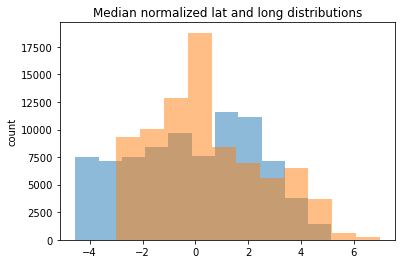

In [138]:
plt.hist(data.longitude-data.longitude.median(), bins=11, alpha=0.5)
plt.hist(data.latitude-data.latitude.median(), bins=11, alpha=0.5)
plt.title('Median normalized lat and long distributions')
plt.ylabel('count')

Create cross-validators with blocks of 30 arc-minutes with shuffling enabled:

In [154]:
spacing = 30 / 60


In [155]:
# Set the random state so that these plots don't vary when we rerun the example
random_state = 10


### Making some functions from the example for later re-use

In [156]:
def kfold(space, _random=random_state, _bal=True):
    '''
    Functionizes the Blockfold function from Verde

    input vars:
    space = spacing, this you will need to define
    _random = random state 
    _bal = balanced or unbalanced, defaults to True
    '''
    fold_model = vd.BlockKFold(
        spacing=space, 
        shuffle=True, 
        random_state=_random,
        balance=_bal)

    return fold_model

In [157]:
kfold_balanced     = kfold(space=spacing, _random=random_state)
kfold_unbalanced   = kfold(space=spacing, _random=random_state, _bal=False)

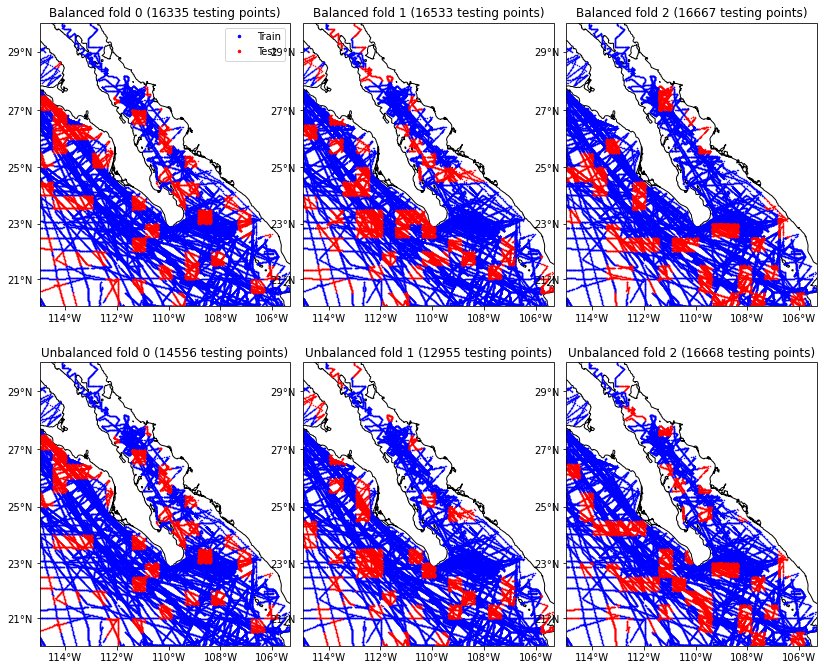

In [158]:
# The BlockKFold is compatible with scikit-learn, so instead of giving it a
# coordinates tuple (like we use in Verde), we have to put the coordinates in a
# feature matrix (X in scikit-learn jargon). Each column will have one of the
# coordinate values. This is usually not required if using this cross-validator
# with Verde functions and classes. You can pass it to verde.cross_val_score,
# for example.
feature_matrix = np.transpose(coordinates)

# Create the folds for the balanced and unbalanced cross-validators to show the
# difference.
balanced = kfold_balanced .split(feature_matrix)
unbalanced = kfold_unbalanced.split(feature_matrix)

# Cartopy requires setting the coordinate reference system (CRS) of the
# original data through the transform argument. Their docs say to use
# PlateCarree to represent geographic data.
crs = ccrs.PlateCarree()

# Make Mercator maps of the two cross-validator folds
fig, axes = plt.subplots(
    2,
    3,
    figsize=(12, 10),
    subplot_kw=dict(projection=ccrs.Mercator()),
    sharex=True,
    sharey=True,
)
for row, title, folds in zip(axes, ["Balanced", "Unbalanced"], [balanced, unbalanced]):
    for i, (ax, fold) in enumerate(zip(row, folds)):
        train, test = fold
        ax.set_title("{} fold {} ({} testing points)".format(title, i, test.size))
        # Use an utility function to setup the tick labels and the land feature
        vd.datasets.setup_baja_bathymetry_map(ax)
        ax.plot(
            coordinates[0][train],
            coordinates[1][train],
            ".b",
            markersize=1,
            transform=crs,
            label="Train",
        )
        ax.plot(
            coordinates[0][test],
            coordinates[1][test],
            ".r",
            markersize=1,
            transform=crs,
            label="Test",
        )
# Place a legend on the first plot
axes[0, 0].legend(loc="upper right", markerscale=5)
plt.subplots_adjust(
    hspace=0.1, wspace=0.05, top=0.95, bottom=0.05, left=0.05, right=0.95
)
plt.show()

# Let's try this with a netCDF example

This is a global temp dataset from Berkely. 

In [144]:
file = 'Complete_TAVG_EqualArea.nc'

In [145]:
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:      (map_points: 5498, time: 3265, month_number: 12)
Coordinates:
    longitude    (map_points) float32 ...
    latitude     (map_points) float32 ...
  * time         (time) float64 1.75e+03 1.75e+03 ... 2.022e+03 2.022e+03
Dimensions without coordinates: map_points, month_number
Data variables:
    land_mask    (map_points) float64 ...
    temperature  (time, map_points) float32 ...
    climatology  (month_number, map_points) float32 ...
Attributes:
    Conventions:          Berkeley Earth Internal Convention (based on CF-1.5)
    title:                Native Format Berkeley Earth Surface Temperature An...
    history:              10-Feb-2022 17:27:48
    institution:          Berkeley Earth Surface Temperature Project
    source_file:          Complete_TAVG.50590s.20220210T171609.mat
    source_history:       07-Feb-2022 15:32:40
    source_data_version:  eead777c589734c11a431a21725e06d3
    comment:              This file contains Berkeley Earth surface temperatu...

We are only pulling one year for temp. This is a big time series dataset! Will have to dive deeper into this.

In [159]:
temp = ds.temperature

temp1d = temp.isel(time=2015)

Making X & Y datapoints. These datapoints are not in a grid. 

In [160]:
x = ds.map_points.longitude.values
y = ds.map_points.latitude.values

In [161]:
bad_indicies = np.array(np.where(np.isnan(temp1d.values)))

This next block of code is to strip out the nan's. Need to dig deeper if this is strictly necessary. 

In [168]:
new_temp = np.delete(temp1d.values, bad_indicies)


new_x = np.delete(x, bad_indicies)
new_y = np.delete(y, bad_indicies)

# Quick sanity check that they are all the same
np.size(new_y) == np.size(new_x) == np.size(new_temp)

coordinates2 = (new_x, new_y)

Spacing (or scale of investigation) is a large knob to turn! I am mostly using non-sensical numbers for demnostration purposes (IE probably way to big).

In [177]:
spacing = (60*10)/ 60 #yes this math is extremely silly

In [178]:
kfold_balanced   = kfold(space=spacing, _random=random_state)
kfold_unbalanced   = kfold(space=spacing, _random=random_state, _bal=False)

# Need to debug these plots

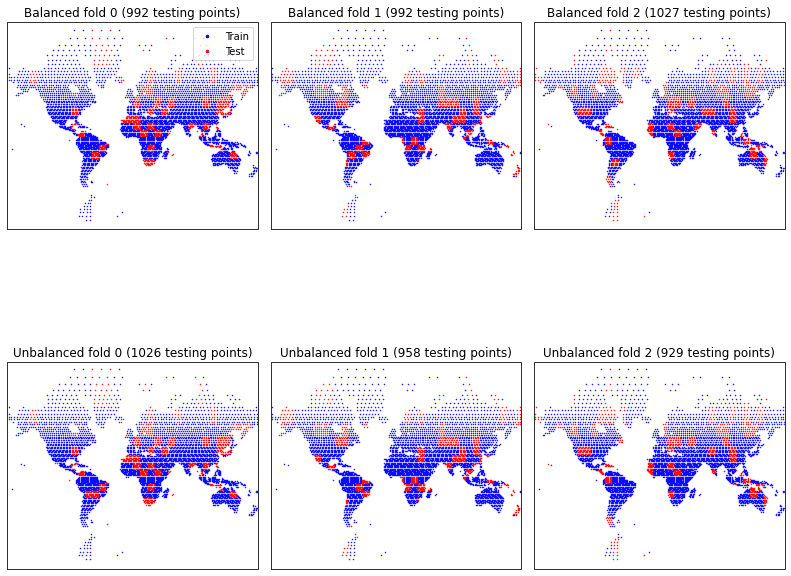

In [179]:
# The BlockKFold is compatible with scikit-learn, so instead of giving it a
# coordinates tuple (like we use in Verde), we have to put the coordinates in a
# feature matrix (X in scikit-learn jargon). Each column will have one of the
# coordinate values. This is usually not required if using this cross-validator
# with Verde functions and classes. You can pass it to verde.cross_val_score,
# for example.
feature_matrix2 = np.transpose(coordinates2)

# Create the folds for the balanced and unbalanced cross-validators to show the
# difference.
balanced = kfold_balanced .split(feature_matrix2)
unbalanced = kfold_unbalanced.split(feature_matrix2)

# Cartopy requires setting the coordinate reference system (CRS) of the
# original data through the transform argument. Their docs say to use
# PlateCarree to represent geographic data.
crs = ccrs.PlateCarree()

# Make Mercator maps of the two cross-validator folds
fig, axes = plt.subplots(
    2,
    3,
    figsize=(12, 10),
    subplot_kw=dict(projection=ccrs.Mercator()),
    sharex=True,
    sharey=True,
)
for row, title, folds in zip(axes, ["Balanced", "Unbalanced"], [balanced, unbalanced]):
    for i, (ax, fold) in enumerate(zip(row, folds)):
        train, test = fold
        ax.set_title("{} fold {} ({} testing points)".format(title, i, test.size))
        # Use an utility function to setup the tick labels and the land feature
        #vd.datasets.setup_baja_bathymetry_map(ax)
        ax.plot(
            coordinates2[0][train],
            coordinates2[1][train],
            ".b",
            markersize=1,
            transform=crs,
            label="Train",
        )
        ax.plot(
            coordinates2[0][test],
            coordinates2[1][test],
            ".r",
            markersize=1,
            transform=crs,
            label="Test",
        )
# Place a legend on the first plot
axes[0, 0].legend(loc="upper right", markerscale=5)
plt.subplots_adjust(
    hspace=0.1, wspace=0.05, top=0.95, bottom=0.05, left=0.05, right=0.95
)
plt.show()

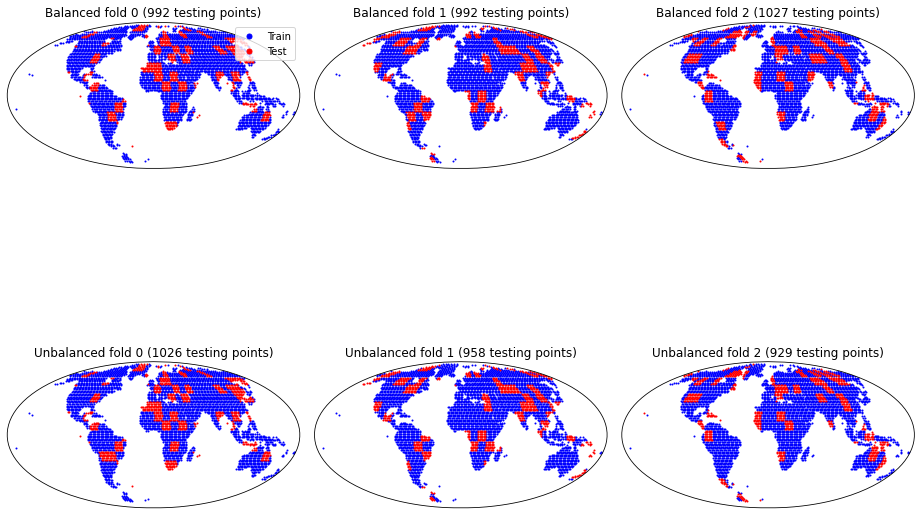

In [180]:
# Create the folds for the balanced and unbalanced cross-validators to show the
# difference.
balanced = kfold_balanced.split(feature_matrix2)
unbalanced = kfold_unbalanced.split(feature_matrix2)

# Cartopy requires setting the coordinate reference system (CRS) of the
# original data through the transform argument. Their docs say to use
# PlateCarree to represent geographic data.
crs = ccrs.PlateCarree()

# Make Mercator maps of the two cross-validator folds
fig, axes = plt.subplots(
    2,
    3,
    figsize=(14, 10),
    subplot_kw=dict(projection=ccrs.Mollweide()),
    sharex=True,
    sharey=True,
)
for row, title, folds in zip(axes, ["Balanced", "Unbalanced"], [balanced, unbalanced]):
    for i, (ax, fold) in enumerate(zip(row, folds)):
        train, test = fold
        ax.set_title("{} fold {} ({} testing points)".format(title, i, test.size))
        # Use an utility function to setup the tick labels and the land feature
        # vd.datasets.setup_baja_bathymetry_map(ax)
        ax.plot(
            coordinates2[0][train],
            coordinates2[1][train],
            ".b",
            markersize=2,
            transform=crs,
            label="Train",
        )
        ax.plot(
            coordinates2[0][test],
            coordinates2[1][test],
            ".r",
            markersize=2,
            transform=crs,
            label="Test",
        )
        #ax.set_xlim([0, 60])
        #ax.set_ylim([-40, 60])

# Place a legend on the first plot
axes[0, 0].legend(loc="upper right", markerscale=5)
plt.subplots_adjust(
    hspace=0.1, wspace=0.05, top=0.95, bottom=0.05, left=0.05, right=0.95
)
plt.show()